In [2]:
# -*- coding: utf-8 -*-
%matplotlib inline
from __future__ import division
import MySQLdb
from IPython.display import Image
from IPython.core.display import HTML 
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.probability import FreqDist
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import math
import numpy as np
import scipy
import scipy.stats
from sklearn import linear_model

stop_words = stopwords.words('english')

# Database connection
The database connection will be left open until end of september 2016

In [3]:
host = '52.58.176.49'
key = 'SystemOfADown'
user = 'dbuser'
db = 'TURK'
connection = MySQLdb.connect(host, user, key, db)

In [4]:
#id, ImgId, Appealing, Course, Free, IsGold, GoldValue, worker, Url
def get_data():
    query = 'SELECT hi.Hid, hi.ImgId, hi.Appealing, hi.Course,'\
                'hi.Free,'\
                'i.IsGold,'\
                'i.GoldValue,'\
                'i.Url,'\
                'h.WorkerId FROM HitImages hi '\
                'LEFT JOIN Images i ON hi.ImgId = i.ImgId '\
                'LEFT JOIN Hits h ON hi.Hid = h.Hid;'
    cursor = connection.cursor( MySQLdb.cursors.DictCursor )
    cursor.execute(query)
    return format_response(cursor.fetchall())

def get_data_v2():
    query = 'SELECT hi.Hid, hi.ImgId, hi.Appealing, hi.Course,'\
                'hi.Free,'\
                'i.IsGold,'\
                'i.GoldValue,'\
                'i.Url,'\
                'h.WorkerId FROM HitImagesV2 hi '\
                'LEFT JOIN Images i ON hi.ImgId = i.ImgId '\
                'LEFT JOIN Hits h ON hi.Hid = h.Hid;'
    cursor = connection.cursor( MySQLdb.cursors.DictCursor )
    cursor.execute(query)
    return format_response(cursor.fetchall())

def get_gold_val(value):
    if not value is None:
        return int(value)
    return 3

def get_free_val(value):
    return value.lower()

def format_response(response):
        return [{'Id': int(x['Hid']),
                 'ImgId': int(x['ImgId']), 
                 'IsGold': int(x['IsGold']),
                 'GoldValue': get_gold_val(x['GoldValue']),
                 'Appealing': int(x['Appealing']),
                 'Course': int(x['Course']),
                 'Free': get_free_val(x['Free']),
                 'WorkerId': x['WorkerId'],
                 'Url': x['Url']} for x in response ]

X = get_data()
X2 = get_data_v2()



In [5]:
def get_spammer_subset(data):
    spammers = []
    sub_set = []
    for entry in data:
        if entry['IsGold'] is 1:
            if entry['Course'] is 2:
                continue
            if not entry['GoldValue'] is entry['Course']:
                spammers.append(entry['WorkerId'])
    
    for entry in data:
        if entry['WorkerId'] in spammers:
            sub_set.append(entry)
    return sub_set

def get_unique_workers(data):
    unique = []
    workers = [w['WorkerId'] for w in data]
    return set(workers)

def get_appealing(data):
    return [x['Appealing'] for x in data]

def remove_spammers(data):
    get
    

In [30]:
spammers = get_spammer_subset(X)
unique_workers = get_unique_workers(X)
unique_spammers = get_unique_workers(spammers)
appealing_spammers = get_appealing(spammers)
appealing = get_appealing(X)

In [31]:
print len(spammers)
print len(unique_workers)
print len(unique_spammers)

1484
205
74


# What gold images failed?
Are the images in fact ambiguous? - Not really...

In [39]:
failed_img = []
for i in spammers:
    if i['IsGold'] is 1:
        failed_img.append(i['Url'])
failed_img = set(failed_img)

for i in failed_img:
    print i


https://s3.eu-central-1.amazonaws.com/turk-food/32.jpg
https://s3.eu-central-1.amazonaws.com/turk-food/95.jpg
https://s3.eu-central-1.amazonaws.com/turk-food/138.jpg
https://s3.eu-central-1.amazonaws.com/turk-food/67.jpg
https://s3.eu-central-1.amazonaws.com/turk-food/159.jpg
https://s3.eu-central-1.amazonaws.com/turk-food/114.jpg
https://s3.eu-central-1.amazonaws.com/turk-food/221.jpg
https://s3.eu-central-1.amazonaws.com/turk-food/91.jpg
https://s3.eu-central-1.amazonaws.com/turk-food/16.jpg
https://s3.eu-central-1.amazonaws.com/turk-food/237.jpg
https://s3.eu-central-1.amazonaws.com/turk-food/43.jpg
https://s3.eu-central-1.amazonaws.com/turk-food/74.jpg
https://s3.eu-central-1.amazonaws.com/turk-food/55.jpg
https://s3.eu-central-1.amazonaws.com/turk-food/63.jpg


# Below is implemented a collection wrapper + Worker + Image + HIT objects

The objects are translating the data, and can be used as the automatable model

In [36]:
class Worker(object):
    def __init__(self, data_entry):
        self.workerId = data_entry['WorkerId'].lower()
        self.tasks = []
        self.correct_gold_items = 0
        self.false_gold_items = 0
        self.netrual_gold_items = 0
    
    def add_task(self, task):
        self.tasks.append(task)
        if(self.__is_gold):
            self.__update_score(task)
            
    def get_gold_metrics(self):
        return { 'Correct': self.correct_gold_items, 
                 'False'  : self.false_gold_items,
                 'Netrual': self.netrual_gold_items }
    
    def get_worker_score(self):
        total = self.get_total_gold_items()
        if total == 0:
            return 0
        return ((self.correct_gold_items * 1) +
                (self.netrual_gold_items * 0)) / self.get_total_gold_items()
    
    def get_total_gold_items(self):
        return self.correct_gold_items + self.false_gold_items 
    
    def equals(self, workerId):
        return self.workerId == workerId.lower()
    
    def __update_score(self, task):
        submitted_val = task['Course']
        gold_value = task['GoldValue']
        if submitted_val is gold_value:
            self.correct_gold_items += 1
        elif submitted_val is 0:
            self.netrual_gold_items +=1
        else:
            self.false_gold_items +=1
    
    def __is_gold(self, task):
        return task['IsGold'] is 1
    
class Collection(object):
    def __init__(self, identifier, itemType):
        self.collection = []
        self.identifier = identifier
        self.create_item = itemType
    
    def add(self, entry):
        item = self.contains(self.__item_id(entry))
        if not item:
            item = self.create_item(entry)
            self.collection.append(item)
        item.add_task(entry)
    
    def get_collection(self):
        return self.collection
    
    def contains(self, itemId):
        for w in self.collection:
            if w.equals(itemId):
                return w
        return None
    
    def __item_id(self, entry):
        return entry[self.identifier]
    
class Image(object):
    def __init__(self, entry_data):
        self.imgId = entry_data['ImgId']
        self.url = entry_data['Url'].lower()
        self.is_gold = entry_data['IsGold'] is 1
        self.gold_value = entry_data['GoldValue']
        self.free_text = []
        self.add_task(entry_data)
    
    def add_task(self, entry_data):
        self.add_formatted_free_text(self.__free_text(entry_data))
    
    def get_metrics(self):
        return { 'Id': self.imgId, 'Free': self.free_text }
    
    def add_formatted_free_text(self, free_text):
        tokens = self.tokenise(free_text)
        for token in tokens:
            if not token == '':
                index = self.contains_token(token)
                if not index is None:
                    self.free_text[index][token] += 1
                else:
                    self.free_text.append(self.__new_token(token))
                    
    def tokenise(self, free_text):
        wnl = WordNetLemmatizer()
        return [unicode(wnl.lemmatize(t.lower())) for t in word_tokenize(free_text, 'english') if t.isalpha() and t not in stop_words]
        
    def contains_token(self, token):
        for i in xrange(len(self.free_text)):
            if token in self.free_text[i]:
                return i
        return None
    
    def equals(self, imgId):
        return self.imgId == imgId
    
    def __free_text(self, entry_data):
        return entry_data['Free'].lower()
    
    def __new_token(self, token):
        return {token: 1}
    
class Hit(object):
    def __init__(self, entry_data):
        self.hid = entry_data['Id']
        self.worker = Worker(entry_data)
        self.images = Collection('ImgId', Image)
        self.correct_gold_items = 0
        self.false_gold_items = 0
        self.netrual_gold_items = 0
    
    def get_total_gold_items(self):
        return [i for i in self.images.get_collection() if i.is_gold]
    
    def get_total_items(self):
        return self.images.get_collection()
    
    def add_task(self, entry_data):
        self.images.add(entry_data)
        self.__update_score(entry_data)
    
    def get_worker_score(self):
        total = self.get_total_gold_items()
        if not total:
            return 0
        return ((self.correct_gold_items * 1) +
                (self.netrual_gold_items * 0)) / len(total)
    
    def equals(self, hid):
        return self.hid == hid
    
    def __update_score(self, task):
        submitted_val = task['Course']
        gold_value = task['GoldValue']
        if submitted_val is gold_value:
            self.correct_gold_items += 1
        elif submitted_val is 0:
            self.netrual_gold_items +=1
        else:
            self.false_gold_items +=1
        

In [37]:
worker_collection = Collection('WorkerId', Worker)

for x in X:
    worker_collection.add(x)

W = worker_collection.get_collection()

In [38]:
worker_scores = [w.get_worker_score() for w in W]

print sum(worker_scores)/len(worker_scores)

0.37347518214


In [15]:
sorted(worker_scores)
metrics = [w.get_gold_metrics() for w in W]
for m in metrics:
    print m

{'Netrual': 0, 'False': 0, 'Correct': 1}
{'Netrual': 15, 'False': 0, 'Correct': 4}
{'Netrual': 17, 'False': 14, 'Correct': 6}
{'Netrual': 1, 'False': 0, 'Correct': 0}
{'Netrual': 3, 'False': 0, 'Correct': 0}
{'Netrual': 8, 'False': 5, 'Correct': 0}
{'Netrual': 1, 'False': 0, 'Correct': 0}
{'Netrual': 1, 'False': 0, 'Correct': 0}
{'Netrual': 1, 'False': 0, 'Correct': 0}
{'Netrual': 5, 'False': 12, 'Correct': 2}
{'Netrual': 12, 'False': 4, 'Correct': 4}
{'Netrual': 2, 'False': 4, 'Correct': 0}
{'Netrual': 1, 'False': 0, 'Correct': 0}
{'Netrual': 11, 'False': 2, 'Correct': 4}
{'Netrual': 7, 'False': 8, 'Correct': 3}
{'Netrual': 1, 'False': 9, 'Correct': 2}
{'Netrual': 9, 'False': 7, 'Correct': 4}
{'Netrual': 7, 'False': 10, 'Correct': 2}
{'Netrual': 1, 'False': 0, 'Correct': 0}
{'Netrual': 6, 'False': 26, 'Correct': 5}
{'Netrual': 0, 'False': 0, 'Correct': 1}
{'Netrual': 6, 'False': 5, 'Correct': 4}
{'Netrual': 4, 'False': 2, 'Correct': 0}
{'Netrual': 6, 'False': 11, 'Correct': 2}
{'Netru

In [16]:
image_collection = Collection('ImgId', Image)

for x in X:
    image_collection.add(x)

images = image_collection.get_collection()

In [17]:

#for i in images:
#    metrics = i.get_metrics()
#    print metrics['Id']
#    for i in metrics['Free']:
#        print i
#    print '\n#########\n'

    # !! 141

In [18]:
hit_collection = Collection('Id', Hit)

for x in X:
    hit_collection.add(x)

hits = hit_collection.get_collection()

In [19]:
for h in hits:
    print '%f : %d : %d'%(h.get_worker_score(), len(h.get_total_items()), len(h.get_total_gold_items()))

1.000000 : 1 : 1
0.800000 : 19 : 5
0.800000 : 19 : 5
0.000000 : 1 : 0
0.000000 : 3 : 0
0.000000 : 13 : 2
0.000000 : 1 : 0
0.000000 : 1 : 0
0.000000 : 1 : 0
0.500000 : 19 : 4
0.750000 : 19 : 4
0.000000 : 6 : 1
0.000000 : 1 : 0
0.800000 : 17 : 5
0.600000 : 17 : 5
0.666667 : 12 : 3
0.666667 : 10 : 3
0.500000 : 19 : 4
0.000000 : 1 : 0
1.000000 : 18 : 5
1.000000 : 1 : 1
1.000000 : 15 : 4
0.000000 : 6 : 0
0.400000 : 19 : 5
1.000000 : 4 : 2
0.750000 : 17 : 4
0.666667 : 10 : 3
1.000000 : 5 : 1
0.666667 : 10 : 3
1.000000 : 12 : 3
1.000000 : 1 : 1
0.000000 : 2 : 1
0.000000 : 2 : 1
0.800000 : 19 : 5
1.000000 : 7 : 1
1.000000 : 8 : 1
1.000000 : 7 : 2
0.750000 : 12 : 4
0.000000 : 5 : 1
1.000000 : 4 : 1
0.000000 : 1 : 0
0.000000 : 1 : 0
0.000000 : 2 : 0
0.750000 : 9 : 4
0.500000 : 7 : 2
0.750000 : 14 : 4
0.600000 : 19 : 5
1.000000 : 8 : 1
0.000000 : 1 : 1
1.000000 : 3 : 1
0.400000 : 18 : 5
0.000000 : 1 : 0
0.500000 : 7 : 2
0.000000 : 1 : 1
0.000000 : 1 : 1
1.000000 : 3 : 2
1.000000 : 13 : 3
0.000000

In [20]:
print h0

NameError: name 'h0' is not defined

# Quality distribution of set X and X2

In [ ]:
A1 = [d['Appealing'] for d in X]

plt.figure(figsize=(10, 5))
bins = np.arange(7) - 0.5
plt.hist(A1, bins=bins, normed=1, alpha=0.5)
plt.xlabel('Image Quality Rating')
plt.ylabel('Frequency')
plt.xticks(range(6))
plt.xlim([0, 6])
plt.show()

In [ ]:
A2 = [d['Appealing'] for d in X2]

plt.figure(figsize=(10, 5))
bins = np.arange(7) - 0.5
plt.hist(A2, bins=bins, normed=1, alpha=0.5)
plt.xlabel('Image Quality Rating')
plt.ylabel('Frequency')
plt.xticks(range(6))
plt.xlim([0, 6])
plt.show()

# Worst and Best rated image of set X and X2

In [41]:
def get_best_and_worst_rated_image(data, precision):
    images = []
    for i in data:
        iid = i['ImgId']
        idx = contains(images, iid)
        qual = i['Appealing']
        if idx:
            images[idx]['score'] += qual
            images[idx]['hits'] += 1
            images[idx]['all_scores'].append(qual)
        else:
            images.append({'ImgId': iid,'score': qual,'hits': 1, 't-score': 0.0, 'all_scores': [qual]})
    
    for i in images:
        i['t-score'] = i['score'] / i['hits']
    return [i for i in sorted(images, key=lambda k: k['t-score']) if i['hits'] > precision]
        
        

def contains(lst, iid):
        for i in xrange(len(lst)):
            if iid == lst[i]['ImgId']:
                return i
        return None

imgs = get_best_and_worst_rated_image(X, 4)
imgs2 = get_best_and_worst_rated_image(X2, 2)

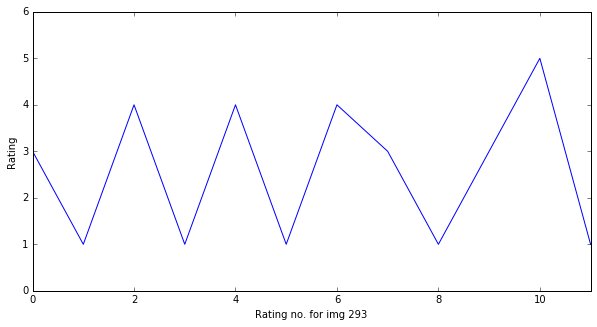

In [42]:
#243
#61

plt.figure(figsize=(10, 5))
plt.plot(imgs[61]['all_scores'])
plt.ylim(0,6)
plt.xlim(0,len(imgs[61]['all_scores'])-1)
plt.xlabel('Rating no. for img %d'%imgs[61]['ImgId'])
plt.ylabel('Rating')
plt.show()

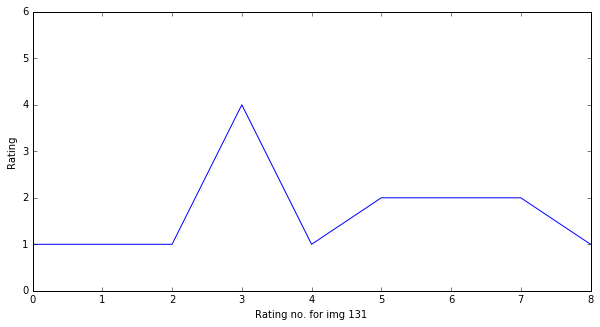

In [43]:
plt.figure(figsize=(10, 5))
plt.plot(imgs[12]['all_scores'])
plt.ylim(0,6)
plt.xlim(0,len(imgs[8]['all_scores']))
plt.xlabel('Rating no. for img %d'%imgs[8]['ImgId'])
plt.ylabel('Rating')
plt.show()

In [44]:
print images[0].get_metrics()

{'Id': 159, 'Free': [{u'pasta': 87}, {u'tomato': 78}, {u'coriander': 4}, {u'green': 14}, {u'cheese': 24}, {u'veggie': 2}, {u'penne': 13}, {u'cucumber': 50}, {u'onion': 33}, {u'spaghetti': 3}, {u'walnut': 8}, {u'spinach': 5}, {u'vegatables': 1}, {u'salad': 20}, {u'vegetable': 4}, {u'rigatoni': 1}, {u'red': 17}, {u'parsley': 2}, {u'mixed': 2}, {u'zuchini': 1}, {u'noodle': 11}, {u'thyme': 1}, {u'zuchinni': 1}, {u'cherry': 5}, {u'leafy': 1}, {u'lettuuce': 1}, {u'arugula': 8}, {u'nut': 4}, {u'lettuce': 9}, {u'chesse': 1}, {u'pepper': 4}, {u'basil': 2}, {u'roka': 1}, {u'purple': 1}, {u'herb': 2}, {u'beef': 1}, {u'ruccola': 1}, {u'cumcumber': 1}, {u'fresh': 1}, {u'mini': 1}, {u'frisee': 1}, {u'squash': 1}, {u'pickle': 3}, {u'grape': 1}, {u'leaf': 2}, {u'rucula': 1}, {u'past': 2}, {u'pastry': 1}, {u'mius': 1}, {u'leafe': 1}, {u'chicken': 1}, {u'zucchini': 2}, {u'parslet': 1}, {u'potato': 3}, {u'etc': 1}, {u'chunk': 1}, {u'sort': 1}, {u'topping': 1}, {u'macirion': 1}, {u'cinnamon': 1}, {u'bread

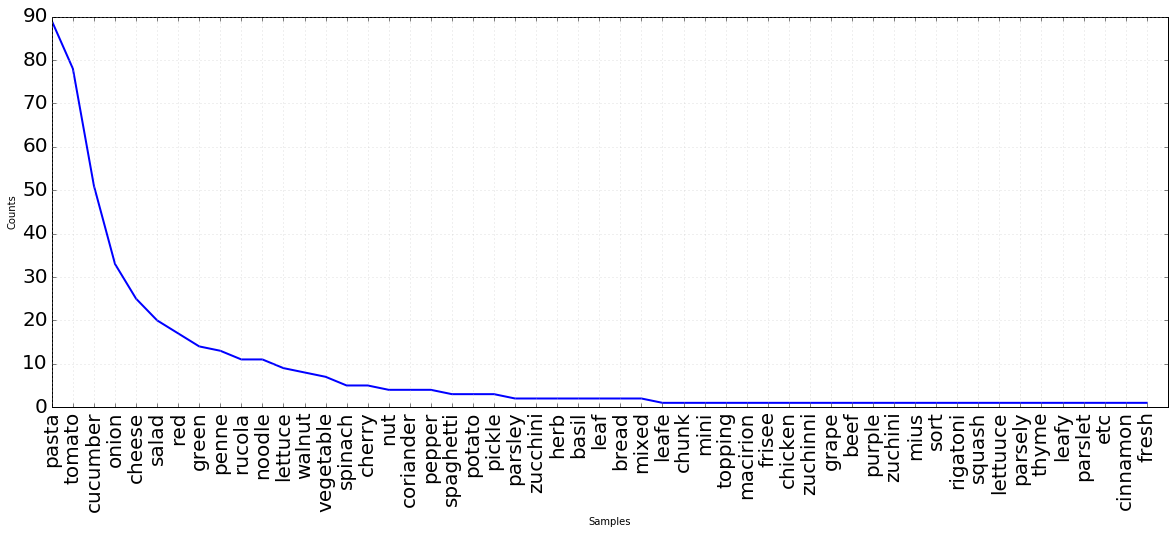

In [45]:
s = ''

def auto_correct(word):
    lookup = {'cumcumber': 'cucumber', 'vegatables': 'vegetable', 'rucula': 'rucola', 'ruccola': 'rucola', 'roka': 'rucola',
              'chesse': 'cheese', 'pastry': 'bread', 'veggie': 'vegetable', 'past': 'pasta', 'picle': 'cucumber', 'arugula': 'rucola'}
    if word in lookup.keys():
        return lookup[word]
    return word

for i in images[0].get_metrics()['Free']:
    for k in i.keys():
        for j in xrange(0, i[k]):
            s += '%s '%(auto_correct(k))



tokens = word_tokenize(s, 'english')
plt.figure(figsize=(20, 7))
plt.xlim(0,len(set(tokens)))
plt.tick_params(axis='both', which='major', labelsize=20)
plt.xlabel('Stemmed tokens')
plt.ylabel('Frequency')
fk = FreqDist(tokens)
fk.plot()

# Cleaning the data using Gold Entries

In [46]:
hit_collection1 = Collection('Id', Hit)
hit_collection2 = Collection('Id', Hit)

for x in X:
    hit_collection1.add(x)

for x in X2:
    hit_collection2.add(x)

hits1 = hit_collection1.get_collection()
hits2 = hit_collection2.get_collection()

In [47]:
percentiles = [0.00, 0.05, 0.10, 0.15, 0.20, 0.25, 0.30, 0.35, 0.40, 0.45, 0.50, 0.55, 0.60, 0.65, 0.70, 0.75, 0.80, 0.85, 0.90, 0.95, 1]

def normalise(data):
    minimum = 0
    counter = max(data) - minimum
    return [ (e - minimum)/(counter) for e in data]

trust_1 = []
trust_2 = []
for p in percentiles:
    trust_1.append(len([h for h in hits1 if h.get_worker_score() >= p])) 
    trust_2.append(len([h for h in hits2 if h.get_worker_score() >= p])) 

print trust_1
    
trust_1 = normalise(trust_1)
trust_2 = normalise(trust_2)


[241, 179, 179, 179, 179, 178, 176, 176, 176, 172, 172, 159, 159, 151, 142, 142, 124, 78, 78, 78, 78]


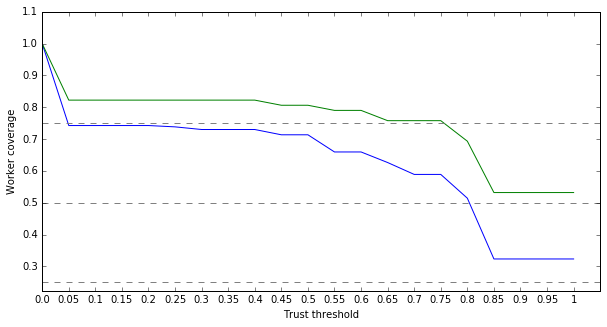

In [48]:
plt.figure(figsize=(10, 5))
line1 = plt.plot(trust_1)
line2 = plt.plot(trust_2)



plt.ylim(min(trust_1)-0.1,max(trust_1)+0.1)
plt.xlim(0,len(trust_1))
plt.xlabel('Trust threshold')
plt.ylabel('Worker coverage')
plt.xticks(xrange(0, len(trust_1)), percentiles)
plt.axhline(y=0.75, xmin=0, xmax = len(trust_1), linewidth=1, color='grey',ls='dashed')
plt.axhline(y=0.50, xmin=0, xmax = len(trust_1), linewidth=1, color='grey',ls='dashed')
plt.axhline(y=0.25, xmin=0, xmax = len(trust_1), linewidth=1, color='grey',ls='dashed')
plt.show()

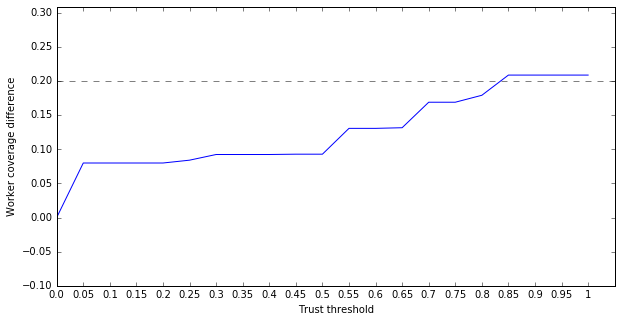

In [49]:
trust_diff = []
for i in xrange(0, len(percentiles)):
    trust_diff.append(trust_2[i] - trust_1[i])
    
plt.figure(figsize=(10, 5))
line1 = plt.plot(trust_diff)
plt.ylim(min(trust_diff)-0.1,max(trust_diff)+0.1)
plt.xlim(0,len(trust_diff))
plt.xlabel('Trust threshold')
plt.ylabel('Worker coverage difference')
plt.axhline(y=0.20, xmin=0, xmax = len(trust_1), linewidth=1, color='grey',ls='dashed')
plt.xticks(xrange(0, len(trust_diff)), percentiles)
plt.show()

{'boxes': [<matplotlib.lines.Line2D at 0x113028290>],
 'caps': [<matplotlib.lines.Line2D at 0x113037110>,
 'fliers': [<matplotlib.lines.Line2D at 0x11303e410>],
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x113037d90>],
 'whiskers': [<matplotlib.lines.Line2D at 0x113028410>,
  <matplotlib.lines.Line2D at 0x113028ad0>]}

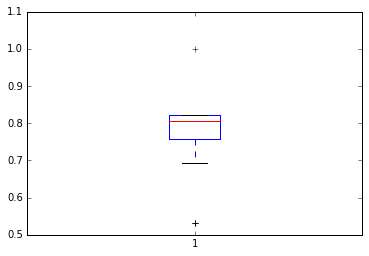

In [50]:
plt.boxplot(trust_2)

{'boxes': [<matplotlib.lines.Line2D at 0x112b6c590>],
 'caps': [<matplotlib.lines.Line2D at 0x112b794d0>,
 'fliers': [<matplotlib.lines.Line2D at 0x112c887d0>],
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x112c88190>],
 'whiskers': [<matplotlib.lines.Line2D at 0x112b6c790>,
  <matplotlib.lines.Line2D at 0x112b6ce50>]}

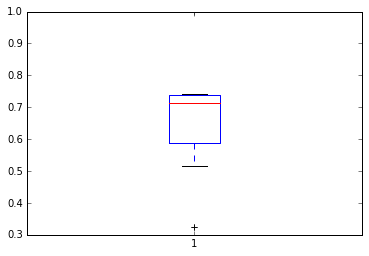

In [51]:
plt.boxplot(trust_1)

In [52]:
trust_1

[1.0,
 0.7427385892116183,
 0.7427385892116183,
 0.7427385892116183,
 0.7427385892116183,
 0.7385892116182573,
 0.7302904564315352,
 0.7302904564315352,
 0.7302904564315352,
 0.7136929460580913,
 0.7136929460580913,
 0.6597510373443983,
 0.6597510373443983,
 0.6265560165975104,
 0.5892116182572614,
 0.5892116182572614,
 0.5145228215767634,
 0.3236514522821577,
 0.3236514522821577,
 0.3236514522821577,
 0.3236514522821577]